In [8]:
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

c:\Users\Yoga 6 R5\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
# Check file or directory is exist
train_df = pd.read_csv("ForestNetDataset/train_new.csv")
val_df = pd.read_csv("ForestNetDataset/val_new.csv")
test_df = pd.read_csv("ForestNetDataset/test_new.csv")

train_df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,merged_label,latitude,longitude,year,example_path
0,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,-1.720266384577504_115.00699582064485
1,Grassland shrubland,Grassland shrubland,-2.709149,113.340780,2016,-2.7091489238834305_113.3407801546713
2,Timber plantation,Plantation,-0.652245,109.920619,2012,-0.6522445100247509_109.9206187702712
3,Oil palm plantation,Plantation,-1.347868,110.527867,2014,-1.3478682873694396_110.52786683455288
4,Grassland shrubland,Grassland shrubland,-2.885256,111.584100,2016,-2.8852555512190485_111.5840999668356


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

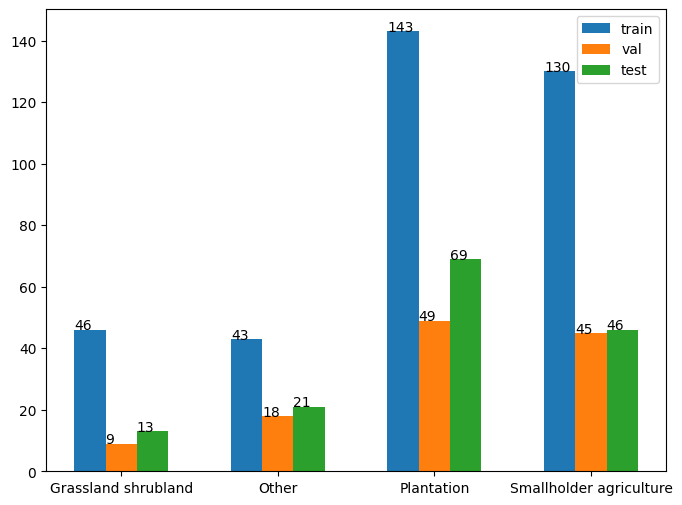

In [3]:
# Plot distribution of data
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

### Updated ForestDataset

In [26]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
from skimage import io
from rasterio.features import rasterize
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import pickle


class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(
        self,
        csv_file_to_df,
        root_dir="ForestNetDataset",
        transform=None,
        types="classifier",
    ):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {
            "Grassland shrubland": 0,
            "Other": 1,
            "Plantation": 2,
            "Smallholder agriculture": 3,
        }
        self.types = types

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []
        if isinstance(polygon, Polygon):
            for i in np.array(polygon.exterior.coords):
                poly_pts.append(tuple(i))
        elif isinstance(polygon, MultiPolygon):
            for p in polygon.geoms:
                for i in np.array(p.exterior.coords):
                    poly_pts.append(tuple(i))
        else:
            raise ValueError(f"Unsupported geometry type: {type(polygon)}")
        return Polygon(poly_pts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image_path = os.path.join(
            self.root_dir, "examples", folder, "images", "visible", "composite.png"
        )
        slope_path = os.path.join(
            self.root_dir, "examples", folder, "auxiliary", "srtm.npy"
        )
        forest_loss_path = os.path.join(
            self.root_dir, "examples", folder, "forest_loss_region.pkl"
        )

        image = io.imread(image_path)
        slope = np.load(slope_path)

        ## Get the segmentation map
        with open(forest_loss_path, "rb") as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0, 2))

        if isinstance(data, (Polygon, MultiPolygon)):
            poly_shp = [self.poly_from_utm(data)]
        else:
            poly_shp = [self.poly_from_utm(poly) for poly in data]

        mask = rasterize(shapes=poly_shp, out_shape=(332, 332))
        seg = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[1]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, seg, slope, merged_label
        else:
            return image,seg, merged_label

In [27]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=None
        ),
    ]
)

In [28]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [29]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset( csv_file_to_df=val_df)
test_dataset = ForestDataset( csv_file_to_df=test_df)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [30]:
dataiter = iter(trainloader)
images, seg, slope, labels = dataiter.__next__()

print('images shape on PyTroch : ', images.size())
print('seg shape on PyTroch : ', seg.size())
print('slope shape on PyTroch : ', slope.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
seg shape on PyTroch :  torch.Size([16, 160, 160])
slope shape on PyTroch :  torch.Size([16, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [31]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 160, 160])
torch.Size([16, 160, 160])


In [32]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [33]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

# Training

In [34]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train','val']:
            if(phase == 'train'):
                model.train() 
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,seg,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                seg=seg.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        optimizer.zero_grad()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [35]:
"""Training Projection Head"""

unet_down_model = UNet(3,1,"projection")
unet_down_model = unet_down_model.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(unet_down_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model_SCL(unet_down_model, criterion, optimizer, scheduler, 20, dataloaders_re)

Epoch 1/20
----------
train Loss: 0.5756
val Loss: 0.5631
Epoch 2/20
----------
train Loss: 0.5740
val Loss: 0.5631
Epoch 3/20
----------
train Loss: 0.5788
val Loss: 0.5629
Epoch 4/20
----------
train Loss: 0.5701
val Loss: 0.5620
Epoch 5/20
----------
train Loss: 0.5649
val Loss: 0.5624
Epoch 6/20
----------
train Loss: 0.5795
val Loss: 0.5623
Epoch 7/20
----------
train Loss: 0.5770
val Loss: 0.5623
Epoch 8/20
----------
train Loss: 0.5772
val Loss: 0.5623
Epoch 9/20
----------
train Loss: 0.5813
val Loss: 0.5623
Epoch 10/20
----------
train Loss: 0.5757
val Loss: 0.5623
Epoch 11/20
----------
train Loss: 0.5712
val Loss: 0.5623
Epoch 12/20
----------
train Loss: 0.5602
val Loss: 0.5623
Epoch 13/20
----------
train Loss: 0.5822
val Loss: 0.5623
Epoch 14/20
----------
train Loss: 0.5815
val Loss: 0.5622
Epoch 15/20
----------
train Loss: 0.5687
val Loss: 0.5623
Epoch 16/20
----------
train Loss: 0.5776
val Loss: 0.5623
Epoch 17/20
----------
train Loss: 0.5686
val Loss: 0.5622
Epoch 

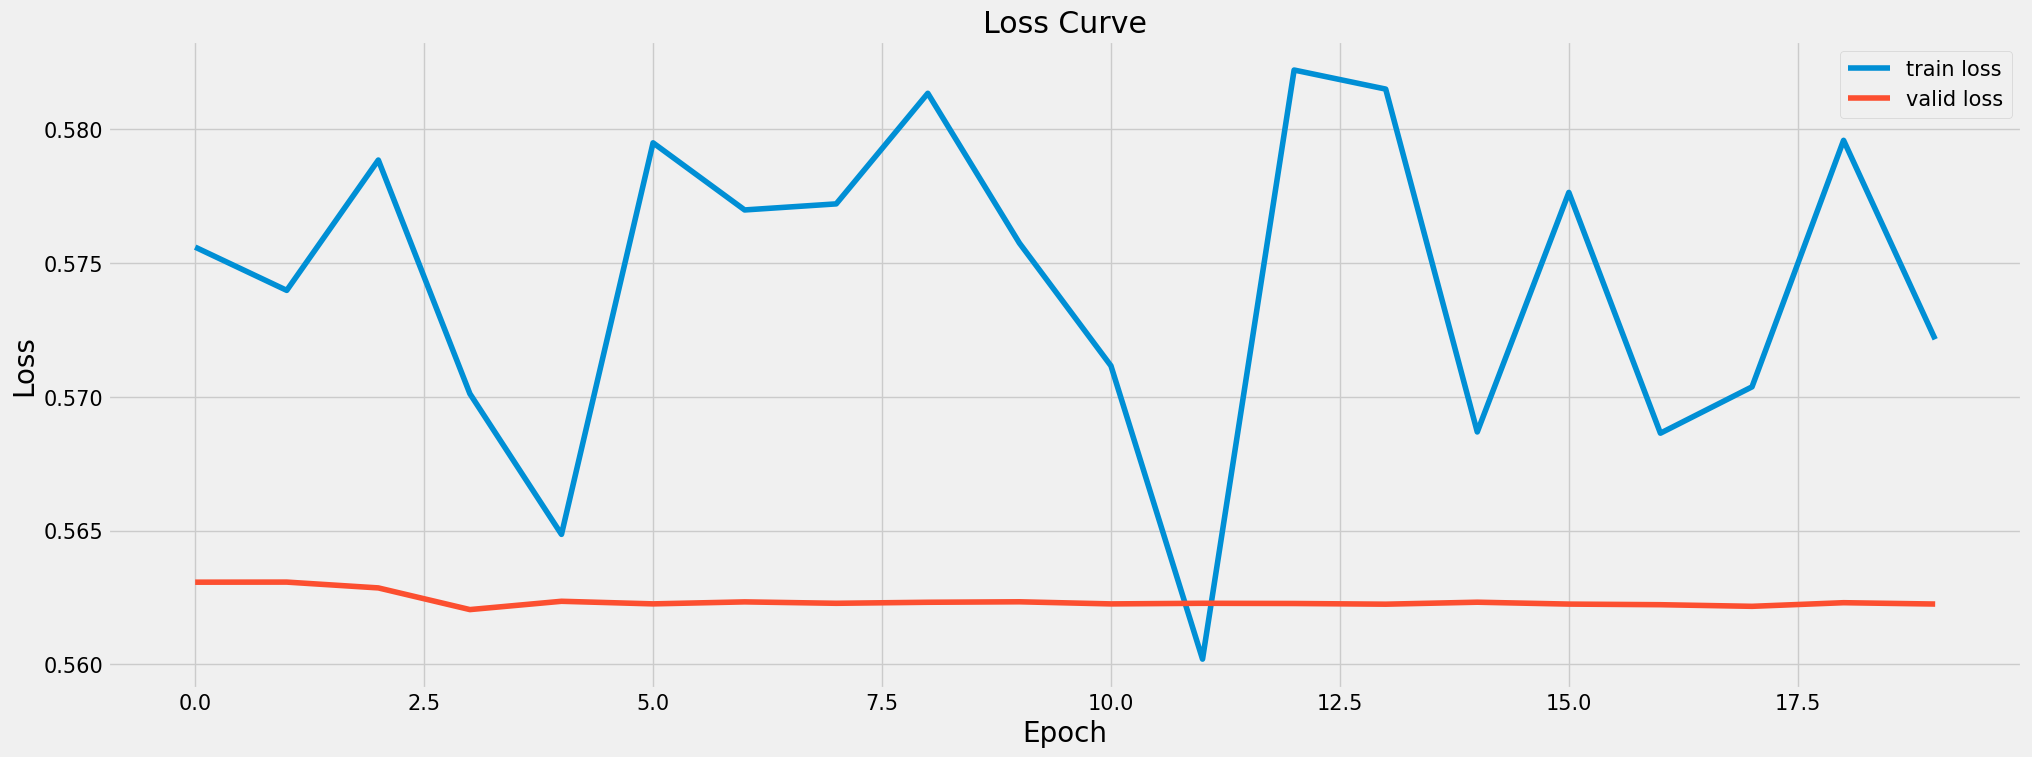

In [36]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "15"

fig = plt.figure(figsize=(22,8))
epochs = list(range(20))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

In [37]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [38]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  

            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, slope, labels in dataloaders[phase]:
                images = images.to(device)
                seg = seg.to(device)
                slope = slope.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images, slope)
                    loss_seg = criterion_seg(outputs, torch.unsqueeze(seg.float(), dim=1))
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, torch.unsqueeze(seg.float(), dim=1))
                running_acc_seg += m_avg.item()
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc Seg: {:.4f} Acc Class: {:.4f}'.format(
                phase, epoch_loss, epoch_acc_seg, epoch_acc_class))
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc_class > best_acc:
                best_acc = epoch_acc_class
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), "best_model.pth")

    return model

In [39]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,1,"classification")
unet_model = unet_model.to(device)

In [40]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

unet_classifier_segmentation = train_model(unet_model, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.4369 Acc Seg: 0.5189 Acc Class: 0.3533
val Loss: 1.3551 Acc Seg: 0.5635 Acc Class: 0.4601
Epoch 2/15
----------
train Loss: 1.0558 Acc Seg: 0.5813 Acc Class: 0.6717
val Loss: 1.4448 Acc Seg: 0.5742 Acc Class: 0.3837
Epoch 3/15
----------
train Loss: 0.8269 Acc Seg: 0.5992 Acc Class: 0.9272
val Loss: 1.4934 Acc Seg: 0.6487 Acc Class: 0.3264
Epoch 4/15
----------
train Loss: 0.7868 Acc Seg: 0.6158 Acc Class: 1.0000
val Loss: 1.5267 Acc Seg: 0.6406 Acc Class: 0.3429
Epoch 5/15
----------
train Loss: 0.7825 Acc Seg: 0.6282 Acc Class: 1.0000
val Loss: 1.5049 Acc Seg: 0.6438 Acc Class: 0.3681
Epoch 6/15
----------
train Loss: 0.7640 Acc Seg: 0.6495 Acc Class: 0.9973
val Loss: 1.5534 Acc Seg: 0.6643 Acc Class: 0.3403
Epoch 7/15
----------
train Loss: 0.7669 Acc Seg: 0.6373 Acc Class: 0.9946
val Loss: 1.5618 Acc Seg: 0.6862 Acc Class: 0.3481
Epoch 8/15
----------
train Loss: 0.7602 Acc Seg: 0.6528 Acc Class: 0.9973
val Loss: 1.5693 Acc Seg: 0.6501 Acc Class:

In [41]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

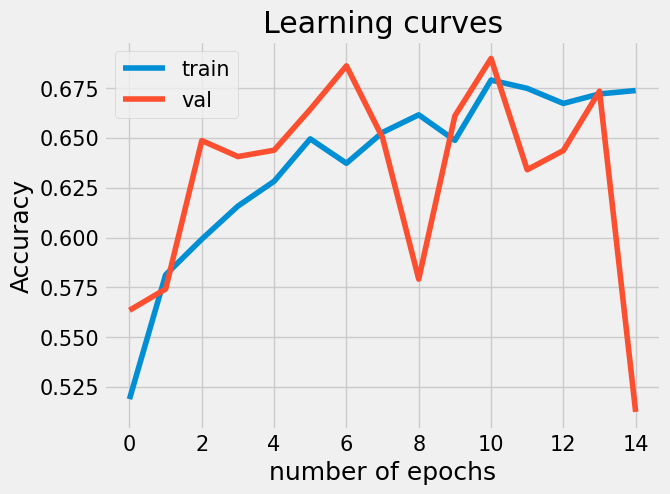

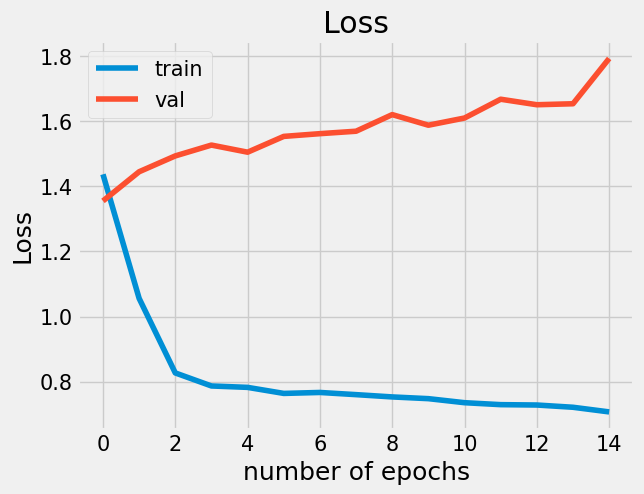

In [42]:
show_curves(acc_seg_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

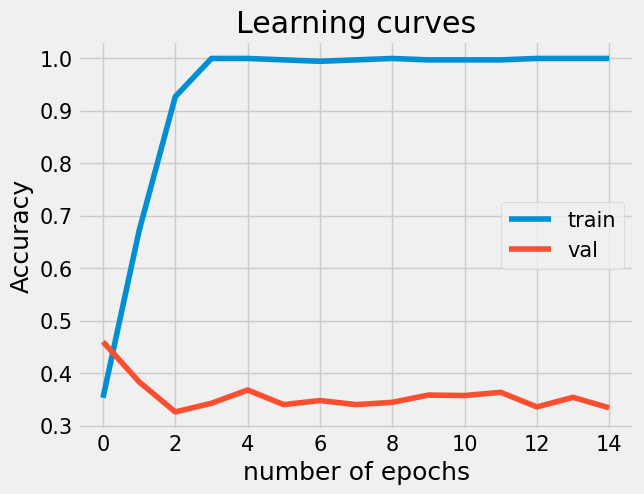

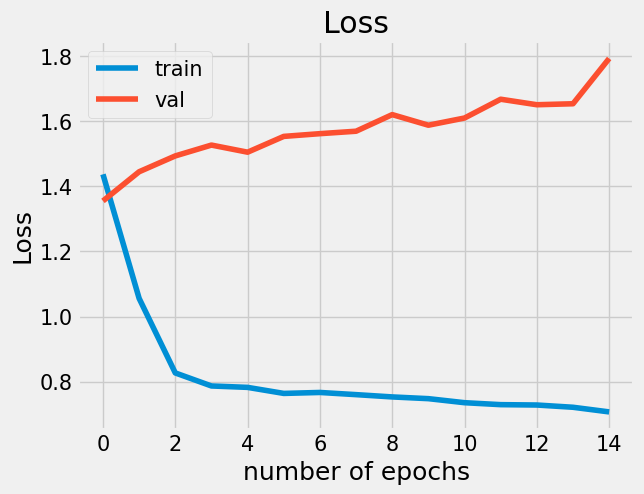

In [43]:
show_curves(acc_class_dict, loss_dict)

In [44]:
def test(model): 
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, slope, labels in testloader: 
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images, slope)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader)))  

In [45]:
test(unet_classifier_segmentation)

Accuracy of the model based on the test set is: 51 %
